# Aim: To identify factors that lead to an accident alongside its severity and identification of accident blackspots.

# Objectives:
__1) Obtain labelled dataset __

__2) Preprocess and integrate dataset __

__3) Analyse dataset and perform dimensionality reduction techniques to identify factors which are highly correlated with accidents __

__4) Train a model with filtered dataset to forecast accident severity __

__5) GUI?? __

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pprint
%matplotlib inline

from scipy.stats import gaussian_kde
from mpl_toolkits.basemap import Basemap
from sklearn import preprocessing
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *

# Import dataset

In [2]:
acc = pd.read_csv('acc2005_2016.csv', low_memory=False)
cas = pd.read_csv('cas2005_2016.csv')
veh = pd.read_csv('veh2005_2016.csv')

# Initialise

## Drop columns/Row
Remove any feature if they meet criteria:
* Duplicate features, where the multiple features are contextually identical but represented differently
* Contextually irrelevant data, i.e. any indexing/referencing features
* Features with > 20% missing data, such data are not useful for the predictors and severely limits learning.

Remove data points which are NaN.

In [3]:
acc.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 
          'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location'], 
         axis=1, inplace=True)

cas.drop(['Age_of_Casualty', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_IMD_Decile', 'Vehicle_Reference', 
          'Casualty_Reference'], 
         axis=1, inplace=True)

veh.drop(['Vehicle_Reference', 'Journey_Purpose_of_Driver', 'Age_of_Driver', 'Engine_Capacity_.CC.', 
          'Propulsion_Code', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile', 'Age_of_Vehicle'], 
         axis=1, inplace=True)

In [4]:
acc.rename(columns={'Local_Authority_.District.': 'Local_Authority_District',
                   'Local_Authority_.Highway.': 'Local_Authority_Highway',
                   'Speed_limit': 'Speed_Limit',
                   'Pedestrian_Crossing.Human_Control': 'Pedestrian_Crossing_Human_Control',
                   'Pedestrian_Crossing.Physical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'}, 
           inplace=True)

veh.rename(columns={'Was_Vehicle_Left_Hand_Drive.': 'Was_Vehicle_Left_Hand_Drive', 
                   'Vehicle_Location.Restricted_Lane': 'Vehicle_Location_Restricted_Lane'}, 
           inplace=True)

acc = acc.dropna(subset=['Longitude', 'Latitude', 'Time'])

1) Convert any date/time series to pandas datetime type

2) Split date and time to denominators of year, month, day, hour and minute

In [5]:
acc.loc[:, ('Date')] = pd.to_datetime(acc['Date'])

acc.loc[:, ('Time')] = pd.to_datetime(acc['Time'], format='%H:%M')

acc = acc.assign(Year=acc.Date.dt.year, Month=acc.Date.dt.month, Day=acc.Date.dt.day, Hour=acc.Time.dt.hour, Minute=acc.Time.dt.minute)

In [6]:
tap = acc.merge(cas, how='inner', on='Accident_Index').merge(veh, how='inner', on='Accident_Index').drop(['Accident_Index'], axis=1)

## Combine all feature

# Function list

Visualise histograms in bulk

In [6]:
def bulkVisualiseHist(fig, data, drop_col, ncol, nrow=-1):
    splt_ind = 1
    data_col = data.columns.drop(drop_col)
    if nrow <= 0:
        nrow = math.ceil(len(data_col) / ncol)
    for i in data_col:
        sfig = fig.add_subplot(nrow, ncol, splt_ind)
        num_bins = len(pd.unique(data[i]))
        if num_bins > 20:
            sfig.hist(data[i])
        else:
            sfig.hist(data[i], bins=num_bins)
        sfig.set_title(i)
        splt_ind += 1
    return splt_ind

Visualise gaussian KDE

__WARNING: iNCREDIBLY SLOW__

In [7]:
def visualiseGaussianKDE(subplot, x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    subplot.scatter(x, y, c=z, s=50, edgecolor='')

Get the sum of values for each class in a feature set

In [8]:
def get_sum_feature_uniq(feature):
    sum_list = pd.unique(feature)
    sum_dict = dict()
    for i in sum_list:
        sum_dict[str(i)] = sum(feature == i)
    return sum_dict

Utility for matplotlib.pyplot.figure

Assign text to global plot X or Y axis

In [9]:
def set_pltxytxt(fig, axis, **kwargs):
    if axis.lower() == 'xy':
        fig.text(0.5, 0.04, kwargs['x'], ha='center')
        fig.text(0.04, 0.5, kwargs['y'], va='center', rotation='vertical')
    elif axis.lower() == 'x':
        fig.text(0.5, 0.04, kwargs['x'], ha='center')
    elif axis.lower() == 'y':
        fig.text(0.04, 0.5, kwargs['y'], va='center', rotation='vertical')
    else:
        print('Axis only accepts "x", "y" and "xy" as inputs')

Count number of missing values in dataset

In [10]:
def checkNegOne(data, **kwargs):
    data_cols = data.columns
    if 'dropcol' in kwargs:
        data_cols = data_cols.drop(kwargs['dropcol'])
    data_len = len(data)
    data_range = range(0, len(data) - 1)
    
    cnt_negs = dict()
    for col in data_cols:
        if np.issubdtype(data[col].loc[1], np.number):
            len_negs = len(list(filter(lambda x: x == -1, data[col])))
            if len_negs > 0:
                cnt_negs[col] = [len_negs, ((len_negs/data_len) * 100)]
    
    return cnt_negs

## Initialise UK bank holiday dates
__Xmas + Boxing day pair seems to have some issues__

In [11]:
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=nearest_workday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=nearest_workday),
        Holiday('Boxing Day', month=12, day=26, observance=after_nearest_workday)
    ]

def after_nearest_workday(dt):
    """
    returns next workday after nearest workday
    needed for Boxing day or multiple holidays in a series
    """
    return next_workday(nearest_workday(dt))

# General analysis

In [24]:
def gen_util_plotter(subplot, **kwargs):
    subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['y'].reshape(-1, 1)), marker='o', label='Accidents')
    if 'cv' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['c'].reshape(-1, 1)), marker='1', label='Casualties')
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(kwargs['cv']['v'].reshape(-1, 1)), marker='8', label='Vehicles')
    if 'sev' in kwargs:
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(np.array(kwargs['sev']['Fatal']).reshape(-1, 1)), marker='s', label='Accident Severity (Fatal)')
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(np.array(kwargs['sev']['Severe']).reshape(-1, 1)), marker='p', label='Accident Severity (Severe)')
        subplot.plot(kwargs['x'], min_max_scaler.fit_transform(np.array(kwargs['sev']['Slight']).reshape(-1, 1)), marker='*', label='Accident Severity (Slight)')
    subplot.legend()
    if 'title' in kwargs:
        subplot.set_title(kwargs['title'])
    if 'set_xticks' in kwargs:
        if kwargs['set_xticks']:
            subplot.set_xticks(x)
    
def gen_xyunzip_list(data, feature):
    return map(np.array, 
                   zip(*[(i, len(data.loc[data[feature] == i])) 
                         for i in range(min(data[feature]), max(data[feature]) + 1)]))

def gen_cv_list(feature, **kwargs):
    if kwargs is None:
        return -1
    ret = dict()
    acc_idx = [acc.loc[acc[feature] == i].set_index('Accident_Index').index 
               for i in range(min(acc[feature]), max(acc[feature]) + 1)]
    if 'c' in kwargs:
        ret['c'] = np.array([len(cas[cas.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    if 'v' in kwargs:
        ret['v'] = np.array([len(veh[veh.set_index('Accident_Index').index.isin(i)]) for i in acc_idx])
    
    return ret

def gen_sev_list(accidents, by_timeline):
    sev_ls = {
        'Fatal': list(),
        'Severe': list(),
        'Slight': list()
    }
    for t in range(min(acc[by_timeline]), max(acc[by_timeline]) + 1):
        sev_ls['Fatal'].append(len(list(filter(lambda x: x == 1, acc['Accident_Severity'].loc[acc[by_timeline] == t]))))
        sev_ls['Severe'].append(len(list(filter(lambda x: x == 2, acc['Accident_Severity'].loc[acc[by_timeline] == t]))))
        sev_ls['Slight'].append(len(list(filter(lambda x: x == 3, acc['Accident_Severity'].loc[acc[by_timeline] == t]))))
        
    return sev_ls

C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


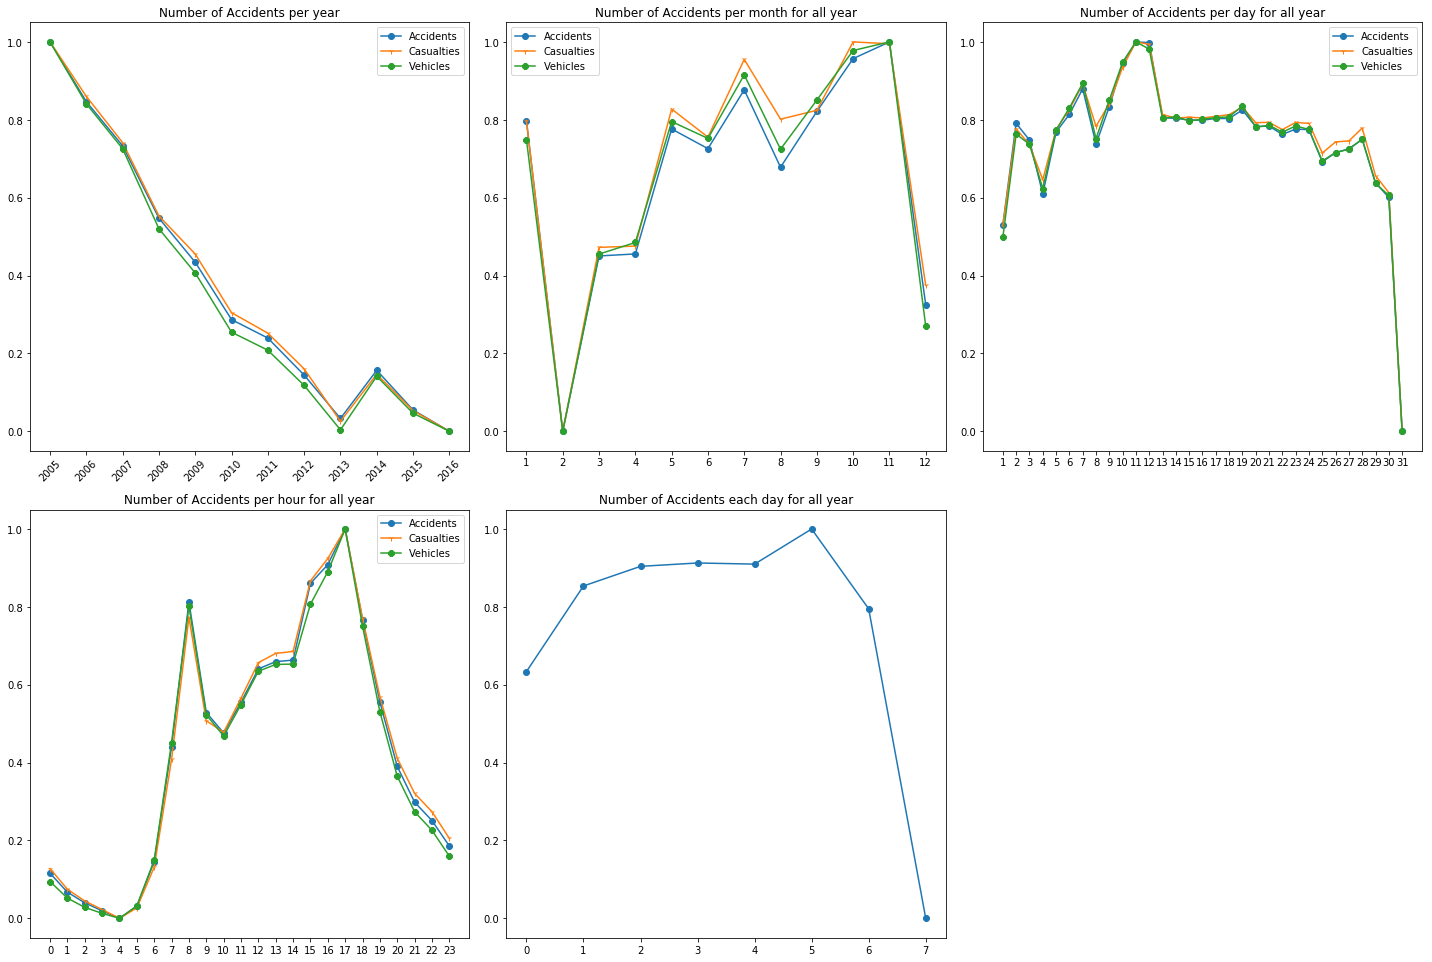

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()
fig_general = plt.figure(figsize=[20,20])
nrow, ncol, splt_ind = 3, 3, 1

# Display plot for accidents per year
x, y = gen_xyunzip_list(acc, 'Year')
cv = gen_cv_list('Year', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per year', set_xticks=True)
ax.set_xticklabels(x, rotation=45)
splt_ind += 1

# Display plot for accident per month for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Month')
cv = gen_cv_list('Month', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per month for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per day for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Day')
cv = gen_cv_list('Day', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per day for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per hour for all years
x, y = gen_xyunzip_list(acc, 'Hour')
cv = gen_cv_list('Hour', c=cas, v=veh)

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, cv=cv, title='Number of Accidents per hour for all year', set_xticks=True)
splt_ind += 1

ukhol = UKBankHolidays()
# Display plot for accident for each day for all years
# Legend:
#    0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday, 7 - Holidays
ukbh = UKBankHolidays()
hols = ukbh.holidays(min(acc.Date), max(acc.Date))

acc_date_ind = acc.set_index('Date').index
acc_hols = acc_date_ind.isin(hols)

x = np.array([i for i in range(0, 8)])
y = np.array([len(acc.loc[acc['Day_of_Week'] == i]) for i in range(1, 8)])
y = np.append(y, [len(list(filter(lambda x: x == True, acc_hols)))])

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
ax.plot(x, min_max_scaler.fit_transform(y.reshape(-1, 1)), marker='o')
ax.set_title('Number of Accidents each day for all year')
ax.set_xticks(x)
splt_ind += 1

plt.tight_layout()
plt.show()

## Accident Severity general analysis

C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\envs\FYP_TAP_ENV\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


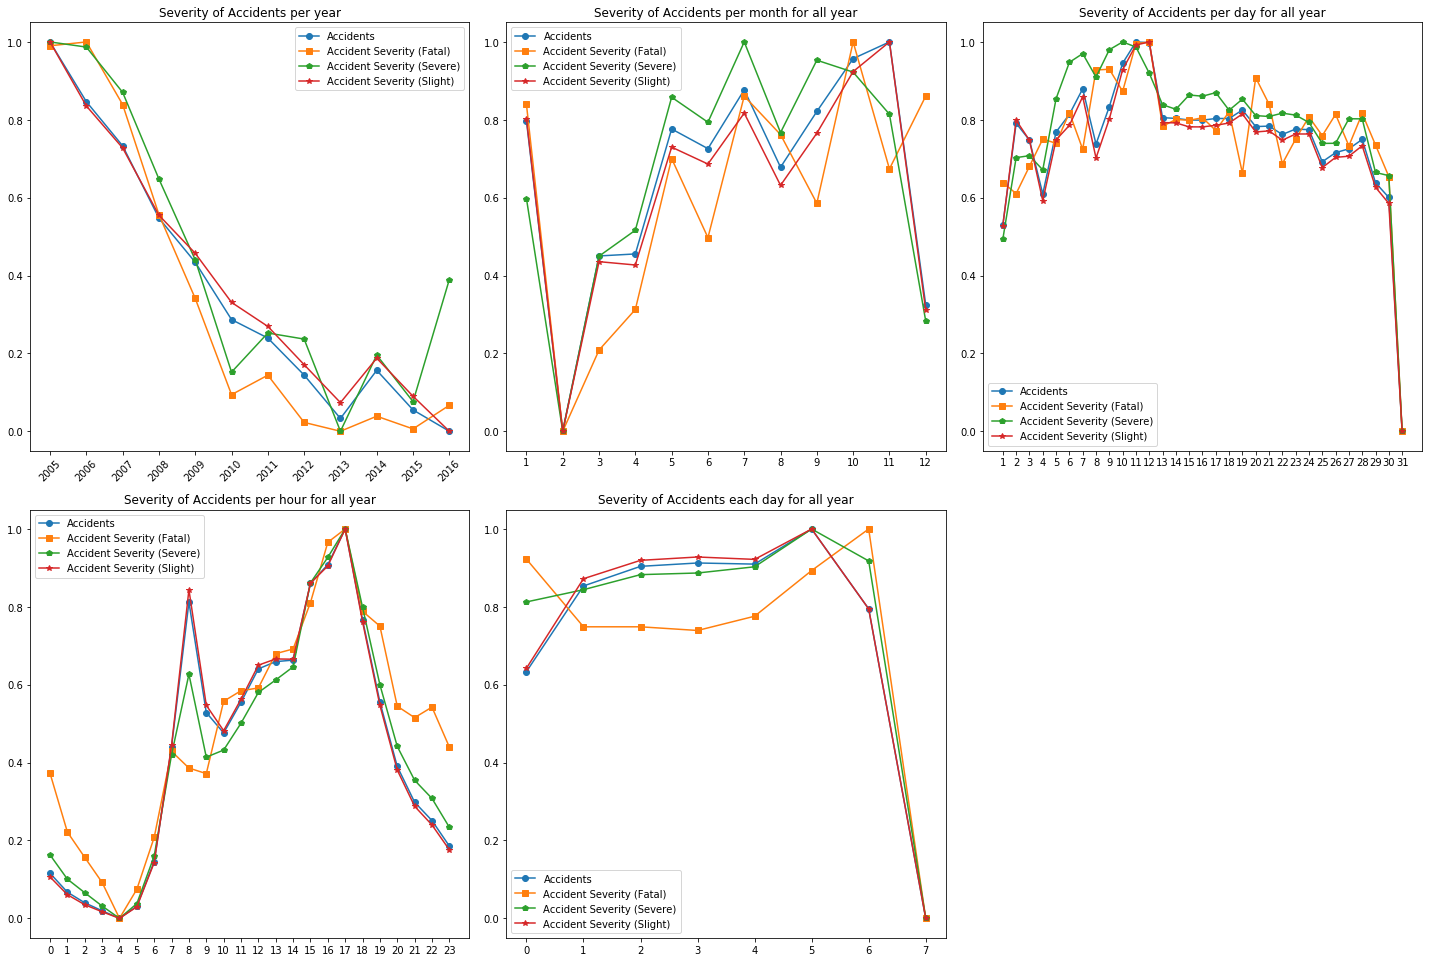

In [59]:
min_max_scaler = preprocessing.MinMaxScaler()
fig_general = plt.figure(figsize=[20,20])
nrow, ncol, splt_ind = 3, 3, 1

# Display plot for accidents per year
x, y = gen_xyunzip_list(acc, 'Year')

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, sev=gen_sev_list(acc, 'Year'), title='Severity of Accidents per year', set_xticks=True)
ax.set_xticklabels(x, rotation=45)
splt_ind += 1

# Display plot for accident per month for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Month')

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, sev=gen_sev_list(acc, 'Month'), title='Severity of Accidents per month for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per day for all years
# Flawed as February may have 28/29 days and disparity in each months total days (30 & 31)
x, y = gen_xyunzip_list(acc, 'Day')

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, sev=gen_sev_list(acc, 'Day'), title='Severity of Accidents per day for all year', set_xticks=True)
splt_ind += 1

# Display plot for accident per hour for all years
x, y = gen_xyunzip_list(acc, 'Hour')

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
gen_util_plotter(ax, x=x, y=y, sev=gen_sev_list(acc, 'Hour'), title='Severity of Accidents per hour for all year', set_xticks=True)
splt_ind += 1

ukhol = UKBankHolidays()
# Display plot for accident for each day for all years
# Legend:
#    0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday, 7 - Holidays
ukbh = UKBankHolidays()
hols = ukbh.holidays(min(acc.Date), max(acc.Date))

acc_date_ind = acc.set_index('Date').index
acc_hols = acc_date_ind.isin(hols)

x = np.array([i for i in range(0, 8)])
y = np.array([len(acc.loc[acc['Day_of_Week'] == i]) for i in range(1, 8)])
y_sev = gen_sev_list(acc, 'Day_of_Week')
y = np.append(y, [len(list(filter(lambda x: x == True, acc_hols)))])
y_sev['Fatal'].append(len(list(filter(lambda x: x == 1, acc.loc[acc_hols]))))
y_sev['Severe'].append(len(list(filter(lambda x: x == 2, acc.loc[acc_hols]))))
y_sev['Slight'].append(len(list(filter(lambda x: x == 3, acc.loc[acc_hols]))))

ax = fig_general.add_subplot(nrow, ncol, splt_ind)
ax.plot(x, min_max_scaler.fit_transform(y.reshape(-1, 1)), marker='o', label='Accidents')
ax.plot(x, min_max_scaler.fit_transform(np.array(y_sev['Fatal']).reshape(-1, 1)), marker='s', label='Accident Severity (Fatal)')
ax.plot(x, min_max_scaler.fit_transform(np.array(y_sev['Severe']).reshape(-1, 1)), marker='p', label='Accident Severity (Severe)')
ax.plot(x, min_max_scaler.fit_transform(np.array(y_sev['Slight']).reshape(-1, 1)), marker='*', label='Accident Severity (Slight)')
ax.legend()
ax.set_title('Severity of Accidents each day for all year')
ax.set_xticks(x)
splt_ind += 1

plt.tight_layout()
plt.show()

## Memory freeing
To run this portion of the code, all unused variables must be purged to keep 4 models in swap and memory

# Missing value impute vs non-impute validation

In [18]:
import gc
del acc, cas, veh, x, y, ax, min_max_scaler, fig_general, cv
gc.collect()

18779

## Functions

In [50]:
def rf_feature_ranking(est_tree, x, show_plot=True):
    importances = est_tree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in est_tree.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    if show_plot:
        # Plot the feature importances of the forest
        plt.figure(figsize=[30,30])
        plt.title("Feature importances")
        plt.bar(range(x.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(x.shape[1]), indices)
        plt.xlim([-1, x.shape[1]])
        plt.show()
    
    return pd.DataFrame(data=[[f, indices[f], importances[indices[f]]] for f in range(x.shape[1])], 
                        columns=['Rank', 'Feature', 'Score']).set_index('Rank')
    
def pca_component_correlation(est_pca, x):
    # Dump components relations with features:
    return pd.DataFrame(pca_est.named_steps.pca.components_,columns=x.columns)
    
def pca_get_eigenvalues(est_pca, X):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.dot(X_centered.T, X_centered) / X.shape[0]
    eigenvalues = est_pca.explained_variance_
    
    return pd.DataFrame(data=[[pca_ind, eigenvalue, np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))] 
            for pca_ind, eigenvalue, eigenvector in 
                              zip([ind for ind in range(0, len(est_pca.components_)+1)], eigenvalues, est_pca.components_)], 
                       columns=['PC', 'Eigenvalue', 'Eigenvector']).set_index('PC')

## Modelling

In [21]:
# Replace -1 with NaN
tap_na = tap.copy().drop(['Date', 'Time'], axis=1)

# Preprocessing
le_jc = preprocessing.LabelEncoder()
le_jc.fit(tap_na.Local_Authority_Highway)
tap_na.loc[:, ('Local_Authority_Highway')] = le_jc.transform(tap_na.Local_Authority_Highway)

for k, v in checkNegOne(tap_na).items():
    tap_na[k] = tap[k].replace(-1, np.nan)

from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

# Compare PCA and RF when missing valued rows are dropped
tap_drop = tap_na.dropna()
x_train, x_test, y_train, y_test = train_test_split(tap_drop.drop(['Accident_Severity'], axis=1), tap_drop.Accident_Severity, test_size=0.3)
pca_est = make_pipeline(StandardScaler(), PCA(n_components=0.75, svd_solver='full'))
rf_est = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=2))

pca_est.fit(x_train, y_train)
pred_pca_test = pca_est.predict(x_test)
print('\nPrediction accuracy for PCA [Dropped rows]')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_pca_test)))

rf_est.fit(x_train, y_train)
pred_rf_test = rf_est.predict(x_test)
print('\nPrediction accuracy for RF [Dropped rows]')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_rf_test)))

# Compare PCA and RF when missing values are imputted with mean
x_train, x_test, y_train, y_test = train_test_split(tap_na.drop(['Accident_Severity'], axis=1), tap_na.Accident_Severity, test_size=0.3)
pca_est_imp = make_pipeline(Imputer(missing_values=np.nan, strategy='mean', axis=0), StandardScaler(), PCA(n_components=0.75, svd_solver='full'))
rf_est_imp = make_pipeline(Imputer(missing_values=np.nan, strategy='mean', axis=0), StandardScaler(), RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=2))

pca_est_imp.fit(x_train, y_train)
pred_pca_test_imp = pca_est_imp.predict(x_test)
print('\nPrediction accuracy for PCA [Imputer]')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_pca_test_imp)))

rf_est_imp.fit(x_train, y_train)
pred_rf_test_imp = rf_est_imp.predict(x_test)
print('\nPrediction accuracy for RF [Imputer]')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_rf_test_imp)))


Prediction accuracy for PCA [Dropped rows]
80.83%


Prediction accuracy for RF [Dropped rows]
97.28%


Prediction accuracy for PCA [Imputer]
82.81%


Prediction accuracy for RF [Imputer]
97.54%



In [51]:
imp_data = Imputer(missing_values=np.nan, strategy='mean', axis=0)
imp_data = imp_data.fit_transform(tap_na.drop(['Accident_Severity'], axis=1))

rf_fr = rf_feature_ranking(rf_est.named_steps.randomforestclassifier, tap_drop.drop(['Accident_Severity'], axis=1), show_plot=False)
rf_fr_imp = rf_feature_ranking(rf_est_imp.named_steps.randomforestclassifier, imp_data, show_plot=False)

pca_cc = pca_component_correlation(pca_est.named_steps.pca, tap_drop.drop(['Accident_Severity'], axis=1))
pca_ev = pca_get_eigenvalues(pca_est.named_steps.pca, tap_drop.drop(['Accident_Severity'], axis=1))

pca_ev_imp = pca_get_eigenvalues(pca_est_imp.named_steps.pca, imp_data)
pca_cc_imp = pca_component_correlation(pca_est_imp.named_steps.pca, tap_na.drop(['Accident_Severity'], axis=1))

In [77]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print('\tRF [Drop]\tRF [Impute]\t\tPCA [Drop]\t\tPCA [Impute]')
display_side_by_side(rf_fr, rf_fr_imp, pca_ev, pca_ev_imp)

	RF [Drop]	RF [Impute]		PCA [Drop]		PCA [Impute]


,Feature,Score
Rank,,
0,29,0.571975
1,3,0.037751
2,1,0.025006
3,0,0.024815
4,5,0.020991
5,25,0.019757
6,8,0.019453
7,23,0.019381
8,6,0.018848


In [58]:
pca_cc

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_District,Local_Authority_Highway,X1st_Road_Class,X1st_Road_Number,Road_Type,...,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,X1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive,Sex_of_Driver,Age_Band_of_Driver,Driver_Home_Area_Type
0,-0.083292,0.050293,0.116050,0.122012,-0.007497,0.198799,0.161486,-0.195255,-0.040548,-0.079211,...,-0.220103,0.185178,0.052878,0.185273,0.193166,-0.049107,0.002432,-0.009539,0.017094,0.238963
1,-0.126378,0.100896,-0.138462,-0.051125,0.005498,0.137536,0.088477,0.110708,-0.009954,0.096330,...,-0.168061,0.089349,0.059076,0.111213,0.120650,-0.027036,0.000879,-0.011174,-0.037056,0.098385
2,0.037329,-0.039740,0.371962,0.363815,0.018314,-0.008307,-0.005138,-0.213991,-0.066211,-0.184551,...,-0.108476,-0.233915,-0.181517,-0.293201,-0.296559,-0.032784,0.003189,0.055981,0.196862,-0.037031
3,0.208557,-0.116365,0.174504,0.241283,-0.001643,-0.261428,-0.200027,-0.118781,-0.061011,-0.160852,...,-0.066398,0.156065,0.156610,0.177852,0.189206,-0.012607,0.003939,-0.102386,-0.270133,-0.321117
4,-0.311374,0.268476,0.041040,0.146322,0.020199,0.156224,0.048562,0.150166,0.147469,0.129882,...,0.134363,-0.001377,-0.021927,0.015160,0.018556,-0.041729,-0.000665,0.213961,-0.147089,0.071487
5,-0.067378,0.128374,-0.180017,-0.106909,-0.008145,-0.099277,-0.098445,-0.058236,0.050396,-0.063418,...,0.049826,0.121302,0.142025,0.195751,0.205968,0.040114,0.019075,-0.133545,0.267874,-0.157180
6,-0.193410,0.180345,0.364387,0.365066,0.021655,0.107680,0.066017,0.203698,0.046235,0.203889,...,-0.004896,0.000981,0.026108,-0.020841,-0.025890,-0.139830,-0.006586,-0.315900,0.052699,-0.053677
7,0.095170,-0.041839,0.116557,0.177544,0.004403,-0.077066,-0.027346,-0.240502,0.178372,-0.137194,...,0.417325,0.055702,0.028962,0.142249,0.115880,0.095623,0.002608,-0.116717,0.114290,0.213566
8,0.353034,-0.301029,0.159474,0.214410,-0.001546,-0.169777,-0.090379,0.297751,-0.128579,0.354536,...,0.027118,0.065061,0.125047,0.186873,0.173105,-0.046203,-0.007182,0.233636,0.096326,0.180127
9,0.067666,-0.075064,-0.044301,0.019061,0.018983,-0.009216,0.027564,0.101050,-0.084697,0.183059,...,0.015535,-0.035047,-0.108979,-0.104250,-0.123081,-0.080185,0.018354,-0.388666,-0.184882,0.154261


In [59]:
pca_cc_imp

,Longitude,Latitude,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_District,Local_Authority_Highway,X1st_Road_Class,X1st_Road_Number,Road_Type,...,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,X1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive,Sex_of_Driver,Age_Band_of_Driver,Driver_Home_Area_Type
0,-0.083292,0.050293,0.116050,0.122012,-0.007497,0.198799,0.161486,-0.195255,-0.040548,-0.079211,...,-0.220103,0.185178,0.052878,0.185273,0.193166,-0.049107,0.002432,-0.009539,0.017094,0.238963
1,-0.126378,0.100896,-0.138462,-0.051125,0.005498,0.137536,0.088477,0.110708,-0.009954,0.096330,...,-0.168061,0.089349,0.059076,0.111213,0.120650,-0.027036,0.000879,-0.011174,-0.037056,0.098385
2,0.037329,-0.039740,0.371962,0.363815,0.018314,-0.008307,-0.005138,-0.213991,-0.066211,-0.184551,...,-0.108476,-0.233915,-0.181517,-0.293201,-0.296559,-0.032784,0.003189,0.055981,0.196862,-0.037031
3,0.208557,-0.116365,0.174504,0.241283,-0.001643,-0.261428,-0.200027,-0.118781,-0.061011,-0.160852,...,-0.066398,0.156065,0.156610,0.177852,0.189206,-0.012607,0.003939,-0.102386,-0.270133,-0.321117
4,-0.311374,0.268476,0.041040,0.146322,0.020199,0.156224,0.048562,0.150166,0.147469,0.129882,...,0.134363,-0.001377,-0.021927,0.015160,0.018556,-0.041729,-0.000665,0.213961,-0.147089,0.071487
5,-0.067378,0.128374,-0.180017,-0.106909,-0.008145,-0.099277,-0.098445,-0.058236,0.050396,-0.063418,...,0.049826,0.121302,0.142025,0.195751,0.205968,0.040114,0.019075,-0.133545,0.267874,-0.157180
6,-0.193410,0.180345,0.364387,0.365066,0.021655,0.107680,0.066017,0.203698,0.046235,0.203889,...,-0.004896,0.000981,0.026108,-0.020841,-0.025890,-0.139830,-0.006586,-0.315900,0.052699,-0.053677
7,0.095170,-0.041839,0.116557,0.177544,0.004403,-0.077066,-0.027346,-0.240502,0.178372,-0.137194,...,0.417325,0.055702,0.028962,0.142249,0.115880,0.095623,0.002608,-0.116717,0.114290,0.213566
8,0.353034,-0.301029,0.159474,0.214410,-0.001546,-0.169777,-0.090379,0.297751,-0.128579,0.354536,...,0.027118,0.065061,0.125047,0.186873,0.173105,-0.046203,-0.007182,0.233636,0.096326,0.180127
9,0.067666,-0.075064,-0.044301,0.019061,0.018983,-0.009216,0.027564,0.101050,-0.084697,0.183059,...,0.015535,-0.035047,-0.108979,-0.104250,-0.123081,-0.080185,0.018354,-0.388666,-0.184882,0.154261
